In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import os
import imageio
import scipy
from scipy import ndimage
import cv2
import tensorflow as tf
from tensorflow.python.framework import ops


In [ ]:
DIR = '/Users/willcheney/Code/Protein CGR/pfam_softmax_data'

num_of_images = 600

cat_counter = [0,0,0,0] #track number of images from each category

X_data = np.empty((0, 193, 291, 3))
Y = np.array([])


   

for img in os.listdir(DIR):
    
    if img == '.DS_Store':
        continue
        
    label = int(img[-5])
    if cat_counter[label] >= num_of_images:
        continue
    
    else:
        cat_counter[label] += 1
        Y = np.append( Y, label) #add Y-label
        

        image = np.array( imageio.imread( os.path.join(DIR, img)))

        image = cv2.resize(image, (0,0), fx = 0.2, fy = 0.2)
        image = image/255.0  # Normalize pixel values
        image = np.delete(image, 3, axis = 2 ) # Remove image metadata

        image = image.reshape((1,193,291,3))

        X_data = np.append(X_data, image[:,:,:,:], axis = 0)

        


(2400, 193, 291, 3)


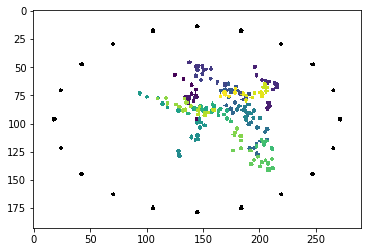

In [3]:
#Check training data is in correct format [training examples, Height, Width, Channels]
print(X_data.shape)
plt.imshow(X_data[0,:,:,:])
plt.show()

In [113]:
np.save('Conv Classifier', X_data)

In [4]:
def shuffle(X, y):
    assert X.shape[0] == y.shape[0], 'X data dimension 0, training examples, should equal labels dimension 0 '
    
    x_shuffled = np.empty(X.shape) 
    y_shuffled = np.empty(y.shape)
    
    
    indices = np.arange(X.shape[0])
    rng = np.random.default_rng()
    rng.shuffle(indices)
    
    x_shuffled[:,:,:,:] = X[indices,:,:,:]
    y_shuffled[:] = y[indices]
    
    
    y_shuffled  = y_shuffled.reshape(len(y_shuffled), 1)
    
    return x_shuffled, y_shuffled

def split_data(X, y, dev_percent, test_percent):
    
    assert X.shape[0] == y.shape[0], 'X data dimension 0, training examples, should equal labels dimension 0 '
    
    train_dev_split_index = math.floor(X.shape[0] * (1 - (dev_percent + test_percent)))
    X_train, X_dev = X[0:train_dev_split_index,:,:,:], X[train_dev_split_index:,:,:,:]
    y_train, y_dev = y[0:train_dev_split_index,:], y[train_dev_split_index:,:]
    
    if test_percent == 0:
        return X_train, X_dev, y_train, y_dev
    
    else:
        dev_test_split_index =  math.floor(X_dev.shape[0] * (1 - test_percent/(dev_percent + test_percent)))
        X_dev, X_test = X_dev[0: dev_test_split_index,:,:,: ], X_dev[dev_test_split_index:,:,:,:]
        y_dev, y_test = y_dev[0: dev_test_split_index,: ], y_dev[dev_test_split_index:,:]


        return X_train, X_dev, X_test, y_train, y_dev, y_test
    

In [5]:
X_shuffled, Y_shuffled = shuffle(X_data, Y)

In [7]:
np.save('Conv_pfam_X_2400', X_shuffled)
np.save('Conv_pfam_Y_2400', Y_shuffled)


In [9]:
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = split_data(X_shuffled, Y_shuffled, .1, .1)

In [10]:
X_train.shape

(1920, 193, 291, 3)

In [186]:
# Plain ConvNN
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

model = tf.keras.models.Sequential(name = 'arch2_with_dropout')

model.add(tf.keras.layers.Input(shape = X_train.shape[1:], name = 'input'))
model.add(tf.keras.layers.Conv2D(8, (8,8), activation = 'relu', padding = 'same', name = 'Conv_a1'))
model.add(tf.keras.layers.Conv2D(16, (4,4), activation = 'relu', padding = 'valid', name = 'Conv_b1'))
model.add(tf.keras.layers.MaxPooling2D(4, strides = (4,4), padding = 'same', name = 'MaxPool_1'))

model.add(tf.keras.layers.Conv2D(32, (2,2), activation = 'relu', name = 'Conv_c1'))
model.add(tf.keras.layers.Conv2D(64, (2,2), activation = 'relu', name = 'Conv_d1'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.MaxPooling2D(2, strides = (2,2), padding = 'same', name = 'MaxPool_2'))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation = 'relu', name = 'Dense_1'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(64, activation = 'relu', name = 'Dense_2'))

model.add(tf.keras.layers.Dense(4, name = 'Classification'))


In [187]:
model.compile(loss = loss, optimizer = optimizer, metrics=['accuracy'])
model.summary()

Model: "arch2_with_dropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_a1 (Conv2D)             (None, 193, 291, 8)       1544      
_________________________________________________________________
Conv_b1 (Conv2D)             (None, 190, 288, 16)      2064      
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 48, 72, 16)        0         
_________________________________________________________________
Conv_c1 (Conv2D)             (None, 47, 71, 32)        2080      
_________________________________________________________________
Conv_d1 (Conv2D)             (None, 46, 70, 64)        8256      
_________________________________________________________________
dropout (Dropout)            (None, 46, 70, 64)        0         
_________________________________________________________________
MaxPool_4 (MaxPooling2D)     (None, 23, 35, 64) 

In [ ]:
model.fit(X_train, Y_train, validation_data = (X_dev, Y_dev), batch_size = 50, epochs = 5, shuffle = True )


Epoch 1/5
26/26 [==============================] - 78s 3s/step - loss: 0.0276 - accuracy: 0.9906 - val_loss: 0.0864 - val_accuracy: 0.9625
Epoch 2/5
26/26 [==============================] - 75s 3s/step - loss: 0.0448 - accuracy: 0.9805 - val_loss: 0.1362 - val_accuracy: 0.9563
Epoch 3/5
26/26 [==============================] - 2312s 89s/step - loss: 0.0343 - accuracy: 0.9867 - val_loss: 0.0857 - val_accuracy: 0.9688
Epoch 4/5
26/26 [==============================] - 4827s 186s/step - loss: 0.0377 - accuracy: 0.9852 - val_loss: 0.0655 - val_accuracy: 0.9688
Epoch 5/5
26/26 [==============================] - 7299s 281s/step - loss: 0.0306 - accuracy: 0.9875 - val_loss: 0.1269 - val_accuracy: 0.9375


In [202]:
model.evaluate(X_test, Y_test)

5/5 [==============================] - 2s 309ms/step - loss: 0.6048 - accuracy: 0.8562


[0.6048263311386108, 0.856249988079071]

In [169]:
temp_X, temp_Y = shuffle(X_train, Y_train)

In [203]:
model.save_weights('./CGR/ConvNN_protein_CGR_classifer_arch:2') 

In [11]:
leNet = tf.keras.models.Sequential(name = 'LeNet_5')
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)


leNet.add(tf.keras.layers.Input(shape = X_train.shape[1:], name = 'input_layer'))
leNet.add(tf.keras.layers.Conv2D(6, (5,5), activation = 'relu', strides = 1, name = 'Conv_a1'))
leNet.add(tf.keras.layers.MaxPool2D((2,2), 2, name = 'Max_Pool_a1'))

leNet.add(tf.keras.layers.Conv2D(16, (5,5), activation = 'relu', strides = 1, name = "Conv_b1"))
leNet.add(tf.keras.layers.MaxPool2D((2,2), 2, name = 'Max_Pool_b1'))

leNet.add(tf.keras.layers.Flatten())
leNet.add(tf.keras.layers.Dense(120, activation = 'relu', name = 'Dense_1'))

leNet.add(tf.keras.layers.Dense(84, activation = 'relu', name = 'Dense_2'))

leNet.add(tf.keras.layers.Dense(4, name = 'Classification'))


In [12]:
leNet.compile(loss = loss, optimizer= optimizer, metrics = ['accuracy'])

In [13]:
leNet.summary()

Model: "LeNet_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_a1 (Conv2D)             (None, 189, 287, 6)       456       
_________________________________________________________________
Max_Pool_a1 (MaxPooling2D)   (None, 94, 143, 6)        0         
_________________________________________________________________
Conv_b1 (Conv2D)             (None, 90, 139, 16)       2416      
_________________________________________________________________
Max_Pool_b1 (MaxPooling2D)   (None, 45, 69, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 49680)             0         
_________________________________________________________________
Dense_1 (Dense)              (None, 120)               5961720   
_________________________________________________________________
Dense_2 (Dense)              (None, 84)                1016

In [ ]:
leNet.fit(X_train, Y_train, validation_data = (X_dev, Y_dev), batch_size = 100, epochs = 5, shuffle = True )


Epoch 1/5
20/20 [==============================] - 45s 2s/step - loss: 7.3588e-04 - accuracy: 1.0000 - val_loss: 0.3937 - val_accuracy: 0.8958
Epoch 2/5
20/20 [==============================] - 40s 2s/step - loss: 6.1360e-04 - accuracy: 1.0000 - val_loss: 0.3947 - val_accuracy: 0.8958
Epoch 3/5
20/20 [==============================] - 39s 2s/step - loss: 5.4177e-04 - accuracy: 1.0000 - val_loss: 0.3966 - val_accuracy: 0.9000
Epoch 4/5
20/20 [==============================] - 40s 2s/step - loss: 4.8762e-04 - accuracy: 1.0000 - val_loss: 0.4035 - val_accuracy: 0.8958
Epoch 5/5
20/20 [==============================] - 69s 3s/step - loss: 4.4861e-04 - accuracy: 1.0000 - val_loss: 0.4107 - val_accuracy: 0.8958


In [19]:
leNet.evaluate(X_test,Y_test)

8/8 [==============================] - 1s 172ms/step - loss: 0.6948 - accuracy: 0.8833


[0.694812536239624, 0.8833333253860474]

In [222]:
leNet.save_weights('./CGR/leNet5') 